# Scott Breitbach

# Case Study: Beans

## Introduction
My initial intention with this project was to utilize a data set from a project I’ve been working on in my job in the hopes of getting not just a better understanding of the process, but hopefully gaining some insights into how the process could be improved. Unfortunately, I quickly realized that the data set I was using was maybe not ideal for applying the techniques I wanted. There is quite a bit of missing data and by the time the useful data was sorted out, there really wasn’t enough left to work with.  

Following this minor setback, I was able to find another data set about dry beans that was not just a better fit, but also appealed to some of my interests. I grew up farming and considered going into plant genetics before falling into microbiology.  So a data set about a food crop felt like a good option with which to proceed.

## Business Problem / Data
Dry beans are an important food crop worldwide. There is a lot of diversity in bean varieties and both classification and seed quality are important factors in the agricultural industry for maximizing production in order to feed the growing world population.  

This data set was created utilizing computer vision to automatically generate 16 features based on high resolution images of 13,611 individuals from 7 different kinds of beans. These features are based on various measurements of the beans on 12 form dimensions (such as area, length, and perimeter) and 4 shape factors.  

With an effective method to classify beans, the agricultural needs of bean uniformity can be met, both in regards to sorting beans as well as quality and consistency within bean varieties.  

Data source: https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset

In [1]:
# !pip install catboost
# !pip install mrmr_selection

In [2]:
# Load Libraries
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from mrmr import mrmr_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed
np.random.seed(42)

### Load Data

In [3]:
# # Load data to a DataFrame
# beanDF = pd.read_excel('data/Dry_Bean_Dataset.xlsx')

In [4]:
# import files to colab
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
def load_dataframe(path):
  # load dataset as pandas DataFrame
  DF = pd.read_csv(path, index_col=0)
  return DF

# load the dataframe
beanDF = pd.read_excel('/content/Dry_Bean_Dataset.xlsx')

Saving Dry_Bean_Dataset.xlsx to Dry_Bean_Dataset.xlsx
User uploaded file "Dry_Bean_Dataset.xlsx" with length 3043341 bytes


In [5]:
# Get a look at the data
beanDF.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


The values for different features vary by orders of magnitude, so these will need to be scaled prior to modeling. 

In [6]:
# Look at the shape of the DataFrame
beanDF.shape

(13611, 17)

In [7]:
# See the relative numbers of each target category
beanDF.value_counts('Class')

Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
dtype: int64

We can see here that an immediate improvement to the data set would be to increase the number of data points for beans like 'CALI', 'BARBUNYA', and particularly 'BOMBAY', or better yet make the entire data set more uniform by increasing the data points for each bean to around 3,500 in order to match 'DERMASON'. 

## Graphical Analysis

In [8]:
# Load libraries
import matplotlib.pyplot as plt

# Set up figure size
plt.rcParams['figure.figsize'] = (12, 8)

### Visualize Relative Counts by Class (the target variable)

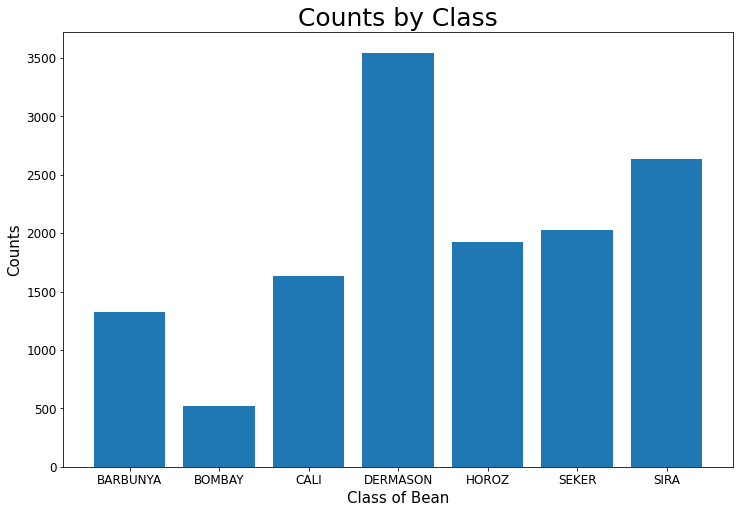

In [9]:
# Get the data ready to feed into the visualizer
X_Class = beanDF.groupby('Class').size().reset_index(name='Counts')['Class']
Y_Class = beanDF.groupby('Class').size().reset_index(name='Counts')['Counts']

# Make the 1st bar plot
plt.bar(X_Class, Y_Class)
plt.title('Counts by Class', fontsize=25)
plt.xlabel('Class of Bean', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.tick_params(axis='both', labelsize=12)

plt.show()

### Visualize Average Values for Each Attribute by Bean Type

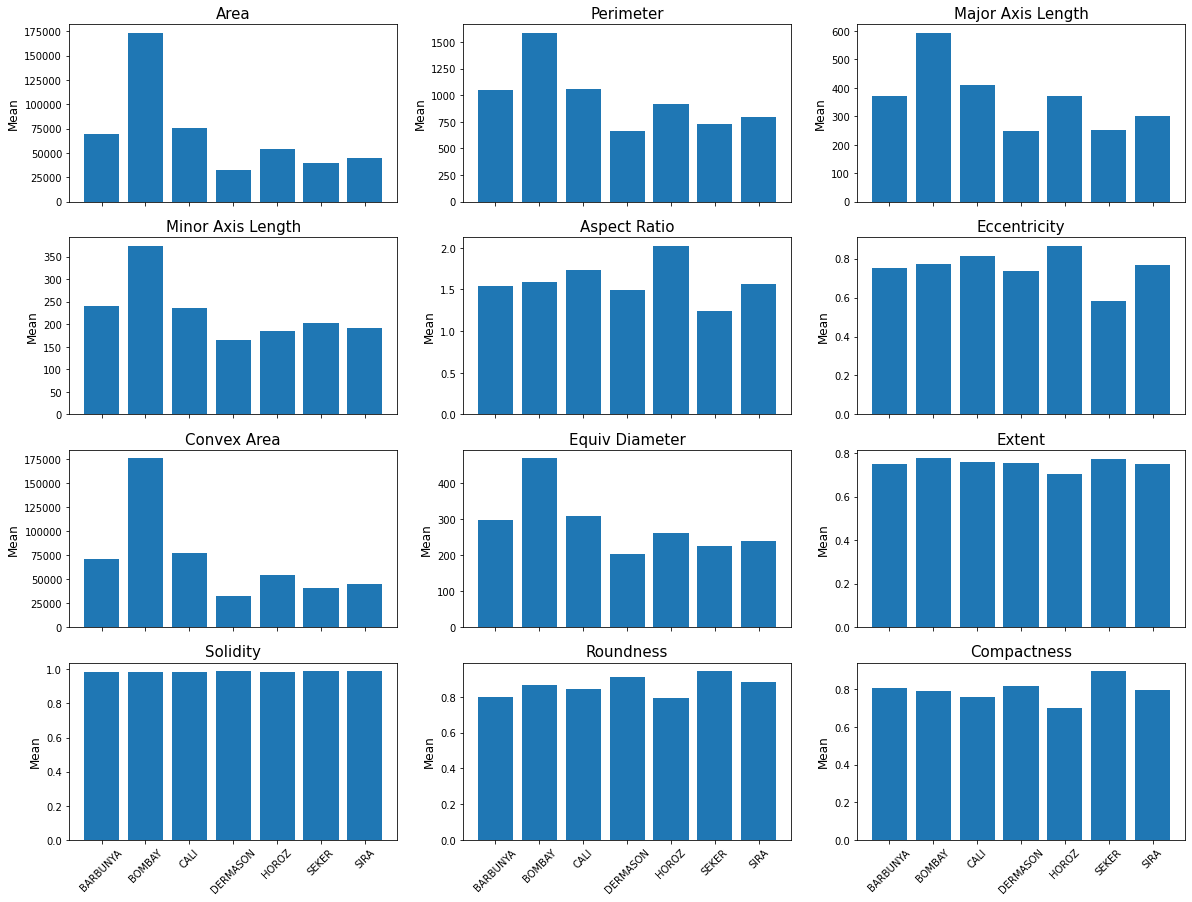

In [10]:
# Set up figure size
plt.rcParams['figure.figsize'] = (20, 15)

# Make subplots
fig, axes = plt.subplots(nrows=4, ncols=3, sharex='col')

# Set font sizes
title  = 15
yLabel = 12
ticks  = 8
# Set up axes / ticks
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.ylabel('Mean', fontsize=yLabel)

## PLOT 1 - AREA
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'Area':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'Area':'mean'}).reset_index('Class')['Area']
# Build chart
axes[0, 0].bar(X_Axis, Y_Axis)
axes[0, 0].set_title('Area', fontsize=title)


## PLOT 2 - PERIMETER
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'Perimeter':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'Perimeter':'mean'}).reset_index('Class')['Perimeter']
# Build chart
axes[0, 1].bar(X_Axis, Y_Axis)
axes[0, 1].set_title('Perimeter', fontsize=title)

## PLOT 3 - MAJOR AXIS LENGTH
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'MajorAxisLength':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'MajorAxisLength':'mean'}).reset_index('Class')['MajorAxisLength']
# Build chart
axes[0, 2].bar(X_Axis, Y_Axis)
axes[0, 2].set_title('Major Axis Length', fontsize=title)

## PLOT 4 - MINOR AXIS LENGTH
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'MinorAxisLength':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'MinorAxisLength':'mean'}).reset_index('Class')['MinorAxisLength']
# Build chart
axes[1, 0].bar(X_Axis, Y_Axis)
axes[1, 0].set_title('Minor Axis Length', fontsize=title)

## PLOT 5 - ASPECT RATIO
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'AspectRation':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'AspectRation':'mean'}).reset_index('Class')['AspectRation']
# Build chart
axes[1, 1].bar(X_Axis, Y_Axis)
axes[1, 1].set_title('Aspect Ratio', fontsize=title)

## PLOT 6 - ECCENTRICITY
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'Eccentricity':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'Eccentricity':'mean'}).reset_index('Class')['Eccentricity']
# Build chart
axes[1, 2].bar(X_Axis, Y_Axis)
axes[1, 2].set_title('Eccentricity', fontsize=title)

## PLOT 7 - CONVEX AREA
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'ConvexArea':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'ConvexArea':'mean'}).reset_index('Class')['ConvexArea']
# Build chart
axes[2, 0].bar(X_Axis, Y_Axis)
axes[2, 0].set_title('Convex Area', fontsize=title)

## PLOT 8 - EQUIV DIAMETER
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'EquivDiameter':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'EquivDiameter':'mean'}).reset_index('Class')['EquivDiameter']
# Build chart
axes[2, 1].bar(X_Axis, Y_Axis)
axes[2, 1].set_title('Equiv Diameter', fontsize=title)

## PLOT 9 - EXTENT
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'Extent':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'Extent':'mean'}).reset_index('Class')['Extent']
# Build chart
axes[2, 2].bar(X_Axis, Y_Axis)
axes[2, 2].set_title('Extent', fontsize=title)

## PLOT 10 - SOLIDITY
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'Solidity':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'Solidity':'mean'}).reset_index('Class')['Solidity']
# Build chart
axes[3, 0].bar(X_Axis, Y_Axis)
axes[3, 0].set_title('Solidity', fontsize=title)

## PLOT 11 - ROUNDNESS
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'roundness':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'roundness':'mean'}).reset_index('Class')['roundness']
# Build chart
axes[3, 1].bar(X_Axis, Y_Axis)
axes[3, 1].set_title('Roundness', fontsize=title)

## PLOT 12 - COMPACTNESS
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'Compactness':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'Compactness':'mean'}).reset_index('Class')['Compactness']
# Build chart
axes[3, 2].bar(X_Axis, Y_Axis)
axes[3, 2].set_title('Compactness', fontsize=title)

plt.show()

### Visualize Average Values for Each Shape Factor by Bean Type

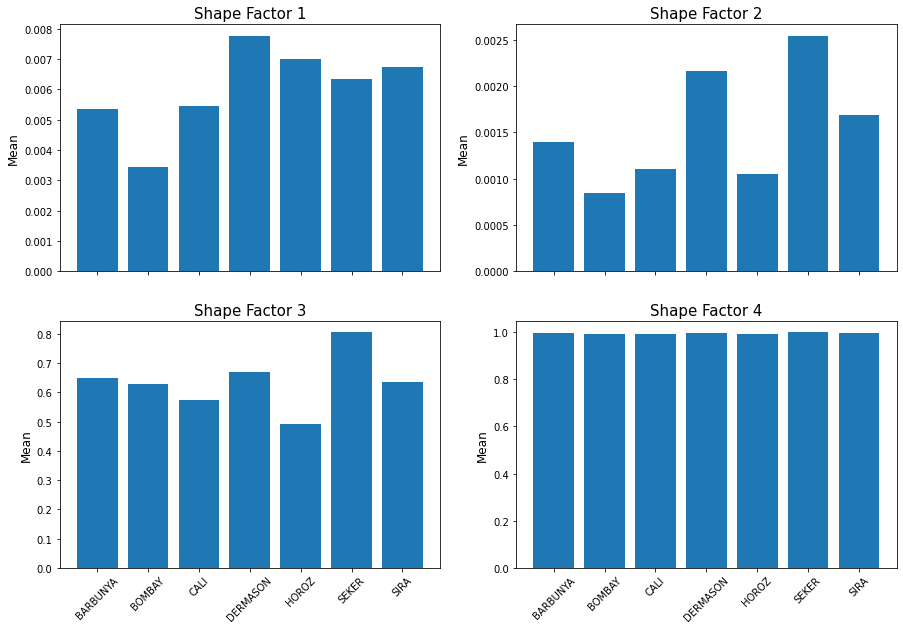

In [11]:
# Set up figure size
plt.rcParams['figure.figsize'] = (15, 10)

# Make subplots
fig, axes = plt.subplots(nrows=2, ncols=2, sharex='col')

# Set font sizes
title  = 15
yLabel = 12
ticks  = 8
# Set up axes / ticks
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.ylabel('Mean', fontsize=yLabel)

## PLOT 1 - SHAPE FACTOR 1
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'ShapeFactor1':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'ShapeFactor1':'mean'}).reset_index('Class')['ShapeFactor1']
# Build chart
axes[0, 0].bar(X_Axis, Y_Axis)
axes[0, 0].set_title('Shape Factor 1', fontsize=title)

## PLOT 2 - SHAPE FACTOR 2
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'ShapeFactor2':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'ShapeFactor2':'mean'}).reset_index('Class')['ShapeFactor2']
# Build chart
axes[0, 1].bar(X_Axis, Y_Axis)
axes[0, 1].set_title('Shape Factor 2', fontsize=title)

## PLOT 4 - SHAPE FACTOR 3
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'ShapeFactor3':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'ShapeFactor3':'mean'}).reset_index('Class')['ShapeFactor3']
# Build chart
axes[1, 0].bar(X_Axis, Y_Axis)
axes[1, 0].set_title('Shape Factor 3', fontsize=title)

## PLOT 5 - SHAPE FACTOR 4
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'ShapeFactor4':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'ShapeFactor4':'mean'}).reset_index('Class')['ShapeFactor4']
# Build chart
axes[1, 1].bar(X_Axis, Y_Axis)
axes[1, 1].set_title('Shape Factor 4', fontsize=title)

plt.show()

Looking at these charts, I would think that the features 'Solidity' and 'ShapeFactor4' would be completely useless, but if we scale the data and chart it again, you can see the variation:

### Standardize Features

In [12]:
# Create a backup copy of the Data Frame
copyDF = beanDF.copy()

In [13]:
# Set up features target set
X = beanDF[beanDF.columns[:-1]]

# Standardize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reapply standardized features to Data Frame
beanDF[beanDF.columns[:-1]] = X

### Visualize Average Values for Standardized Attributes by Bean Type

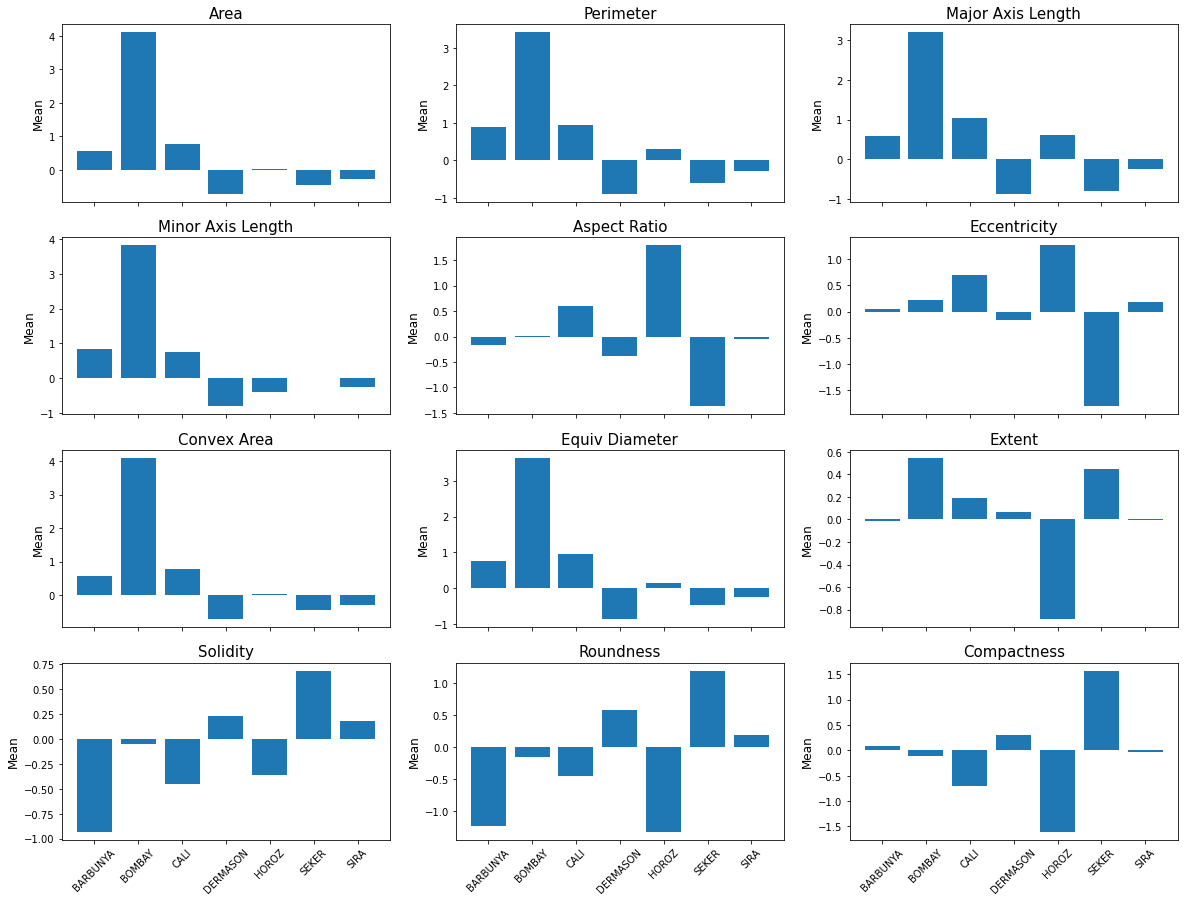

In [14]:
# Set up figure size
plt.rcParams['figure.figsize'] = (20, 15)

# Make subplots
fig, axes = plt.subplots(nrows=4, ncols=3, sharex='col')

# Set font sizes
title  = 15
yLabel = 12
ticks  = 8
# Set up axes / ticks
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.ylabel('Mean', fontsize=yLabel)

## PLOT 1 - AREA
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'Area':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'Area':'mean'}).reset_index('Class')['Area']
# Build chart
axes[0, 0].bar(X_Axis, Y_Axis)
axes[0, 0].set_title('Area', fontsize=title)


## PLOT 2 - PERIMETER
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'Perimeter':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'Perimeter':'mean'}).reset_index('Class')['Perimeter']
# Build chart
axes[0, 1].bar(X_Axis, Y_Axis)
axes[0, 1].set_title('Perimeter', fontsize=title)

## PLOT 3 - MAJOR AXIS LENGTH
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'MajorAxisLength':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'MajorAxisLength':'mean'}).reset_index('Class')['MajorAxisLength']
# Build chart
axes[0, 2].bar(X_Axis, Y_Axis)
axes[0, 2].set_title('Major Axis Length', fontsize=title)

## PLOT 4 - MINOR AXIS LENGTH
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'MinorAxisLength':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'MinorAxisLength':'mean'}).reset_index('Class')['MinorAxisLength']
# Build chart
axes[1, 0].bar(X_Axis, Y_Axis)
axes[1, 0].set_title('Minor Axis Length', fontsize=title)

## PLOT 5 - ASPECT RATIO
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'AspectRation':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'AspectRation':'mean'}).reset_index('Class')['AspectRation']
# Build chart
axes[1, 1].bar(X_Axis, Y_Axis)
axes[1, 1].set_title('Aspect Ratio', fontsize=title)

## PLOT 6 - ECCENTRICITY
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'Eccentricity':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'Eccentricity':'mean'}).reset_index('Class')['Eccentricity']
# Build chart
axes[1, 2].bar(X_Axis, Y_Axis)
axes[1, 2].set_title('Eccentricity', fontsize=title)

## PLOT 7 - CONVEX AREA
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'ConvexArea':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'ConvexArea':'mean'}).reset_index('Class')['ConvexArea']
# Build chart
axes[2, 0].bar(X_Axis, Y_Axis)
axes[2, 0].set_title('Convex Area', fontsize=title)

## PLOT 8 - EQUIV DIAMETER
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'EquivDiameter':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'EquivDiameter':'mean'}).reset_index('Class')['EquivDiameter']
# Build chart
axes[2, 1].bar(X_Axis, Y_Axis)
axes[2, 1].set_title('Equiv Diameter', fontsize=title)

## PLOT 9 - EXTENT
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'Extent':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'Extent':'mean'}).reset_index('Class')['Extent']
# Build chart
axes[2, 2].bar(X_Axis, Y_Axis)
axes[2, 2].set_title('Extent', fontsize=title)

## PLOT 10 - SOLIDITY
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'Solidity':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'Solidity':'mean'}).reset_index('Class')['Solidity']
# Build chart
axes[3, 0].bar(X_Axis, Y_Axis)
axes[3, 0].set_title('Solidity', fontsize=title)

## PLOT 11 - ROUNDNESS
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'roundness':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'roundness':'mean'}).reset_index('Class')['roundness']
# Build chart
axes[3, 1].bar(X_Axis, Y_Axis)
axes[3, 1].set_title('Roundness', fontsize=title)

## PLOT 12 - COMPACTNESS
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'Compactness':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'Compactness':'mean'}).reset_index('Class')['Compactness']
# Build chart
axes[3, 2].bar(X_Axis, Y_Axis)
axes[3, 2].set_title('Compactness', fontsize=title)

plt.show()

### Visualize Average Values for Standardized Shape Factors by Bean Type

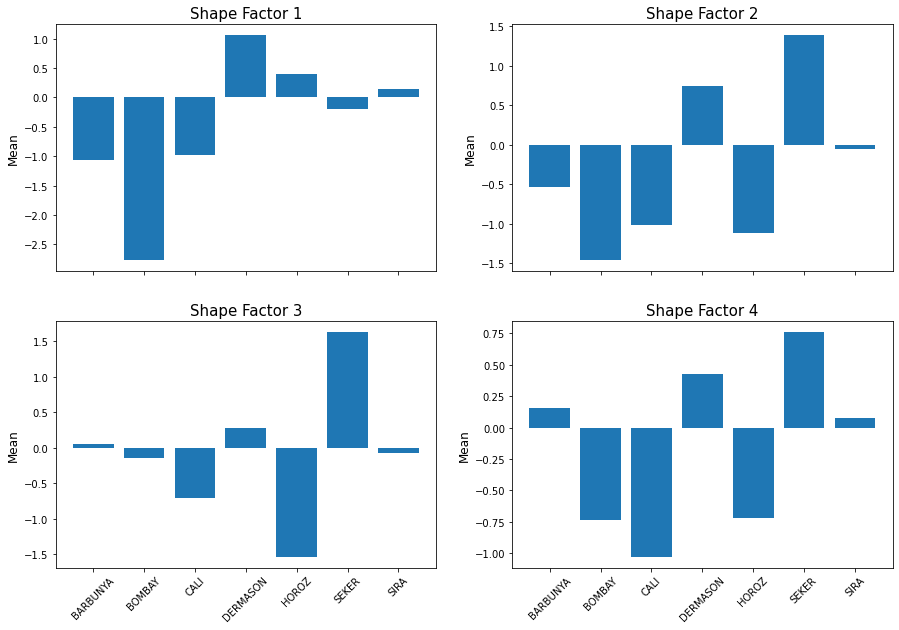

In [15]:
# Set up figure size
plt.rcParams['figure.figsize'] = (15, 10)

# Make subplots
fig, axes = plt.subplots(nrows=2, ncols=2, sharex='col')

# Set font sizes
title  = 15
yLabel = 12
ticks  = 8
# Set up axes / ticks
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.ylabel('Mean', fontsize=yLabel)

## PLOT 1 - SHAPE FACTOR 1
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'ShapeFactor1':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'ShapeFactor1':'mean'}).reset_index('Class')['ShapeFactor1']
# Build chart
axes[0, 0].bar(X_Axis, Y_Axis)
axes[0, 0].set_title('Shape Factor 1', fontsize=title)

## PLOT 2 - SHAPE FACTOR 2
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'ShapeFactor2':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'ShapeFactor2':'mean'}).reset_index('Class')['ShapeFactor2']
# Build chart
axes[0, 1].bar(X_Axis, Y_Axis)
axes[0, 1].set_title('Shape Factor 2', fontsize=title)

## PLOT 4 - SHAPE FACTOR 3
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'ShapeFactor3':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'ShapeFactor3':'mean'}).reset_index('Class')['ShapeFactor3']
# Build chart
axes[1, 0].bar(X_Axis, Y_Axis)
axes[1, 0].set_title('Shape Factor 3', fontsize=title)

## PLOT 5 - SHAPE FACTOR 4
# Group by 'Class'
X_Axis = beanDF.groupby('Class').aggregate({'ShapeFactor4':'mean'}).reset_index('Class')['Class']
Y_Axis = beanDF.groupby('Class').aggregate({'ShapeFactor4':'mean'}).reset_index('Class')['ShapeFactor4']
# Build chart
axes[1, 1].bar(X_Axis, Y_Axis)
axes[1, 1].set_title('Shape Factor 4', fontsize=title)

plt.show()

In [16]:
# Restore original bean DataFrame
beanDF = copyDF.copy()

## Dimensionality & Feature Reduction / Engineering

### Split Training and Testing Data

In [17]:
# Set up features target sets
X = beanDF[beanDF.columns[:-1]]
y = beanDF.Class

# Encode the target variables
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, 
                                                    random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test  = scaler.transform(X_test)

### Feature Selection
We'll try out 5 methods for selecting the best features and compare the results of each.

#### 1. F-Statistic
The result of the ANOVA F-test, comparing variability between- and within-groups.

In [18]:
# Feature selection using F-statistic
f = f_classif(X_train, y_train)[0]

#### 2. Mutual Information
A mesure of mutual dependence between two variables.

In [19]:
# Feature selection using mutual information
mi = mutual_info_classif(X_train, y_train)

#### 3. Logistic Regression
Relative importance of features based on fitting a logistic regression to the data.

In [20]:
# Feature selection using logistic regression
logreg = LogisticRegression(max_iter=500).fit(X_train, y_train)

#### 4. LightGBM (Light Gradient Boosting Machine)
Using another predictive model (this one based on decision tree) to fit data for estimating relative importance.

In [21]:
# Feature selection using light gbm
lgbm = LGBMClassifier(
    objective = 'multiclass',
    metric = 'multi_logloss',
    importance_type = 'gain'
).fit(X_train, y_train)

#### 5. MRMR (Maximum Relevance Minimum Redundancy)
Identify features with high relevance to the target variable, but small redundancy with each other.

In [22]:
# Feature selection using
mrmr = mrmr_classif(pd.DataFrame(X_train), pd.Series(y_train), K = 784)

100%|██████████| 16/16 [00:00<00:00, 36.32it/s]


#### Store Results

In [23]:
# Create DF to store feature ranking info
ranking = pd.DataFrame(index = range(X_train.shape[1]))

# Store ranking info for each feature from each method
ranking['feat'] = X.columns
ranking['f'] = pd.Series(f, index = ranking.index).fillna(0).rank(ascending = False)
ranking['mi'] = pd.Series(mi, index = ranking.index).fillna(0).rank(ascending = False)
ranking['logreg'] = pd.Series(np.abs(logreg.coef_).mean(axis = 0), index = ranking.index).rank(ascending = False)
ranking['lightgbm'] = pd.Series(lgbm.feature_importances_, index = ranking.index).rank(ascending = False)
ranking['mrmr'] = pd.Series(list(range(1, len(mrmr) + 1)) + [X_train.shape[1]] * (X_train.shape[1] - len(mrmr)), index = mrmr + list(set(ranking.index) - set(mrmr))).sort_index()

ranking = ranking.replace(to_replace = ranking.max(), value = X_train.shape[1])
ranking.to_csv('ranking.csv', index = False)

##### Compare results and sum across rows to rank overall best/worst features

In [24]:
# Sum the rankings across methods
ranking['total'] = ranking.sum(axis=1)
# Sort by sum to get an overall idea of the most/least useful features
ranking.sort_values('total')

,feat,f,mi,logreg,lightgbm,mrmr,total
0,Area,1.0,3.0,10.0,2.0,1,17.0
6,ConvexArea,2.0,4.0,8.0,3.0,4,21.0
1,Perimeter,4.0,1.0,5.0,6.0,6,22.0
3,MinorAxisLength,5.0,7.0,2.0,8.0,3,25.0
7,EquivDiameter,3.0,2.0,6.0,14.0,5,30.0
2,MajorAxisLength,6.0,5.0,7.0,5.0,8,31.0
12,ShapeFactor1,8.0,8.0,1.0,4.0,10,31.0
13,ShapeFactor2,7.0,6.0,3.0,10.0,12,38.0
11,Compactness,10.0,9.0,14.0,1.0,7,41.0
4,AspectRation,9.0,11.0,11.0,11.0,2,44.0


Solidity and Extent were considered the least useful in 4 of the 5 methods. They may be prime candidates for removal.

### Predictive Performance on Top Features
Visualize which methods works best for feature selection

In [25]:
%%time
# Evaluate accuracy vs features using each feaure selection technique
algos = ['f', 'mi', 'logreg', 'lightgbm', 'mrmr']
ks = [1, 2, 3, 4, 5, 7, 9, 11, 13, 16]

accuracy = pd.DataFrame(index = ks, columns = algos)
roc = pd.DataFrame(index = ks, columns = algos)

for algo in algos:
    
    for k in ks:
    
        cols = ranking[algo].sort_values().head(k).index.to_list()
                
        clf = CatBoostClassifier().fit(
            X_train[:, cols], y_train,
            eval_set = (X_test[:, cols], y_test),
            early_stopping_rounds = 20,
            verbose = False
        )
                
        accuracy.loc[k, algo] = accuracy_score(
            y_true = y_test, y_pred = clf.predict(X_test[:, cols]))
        roc.loc[k, algo] = roc_auc_score(
            y_true = y_test, y_score = clf.predict_proba(X_test[:, cols]), multi_class = 'ovr', average = 'macro')
        
accuracy.to_csv('accuracy.csv', index = True)
roc.to_csv('roc.csv', index = True)

CPU times: user 9min 18s, sys: 15.3 s, total: 9min 33s
Wall time: 5min 25s


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


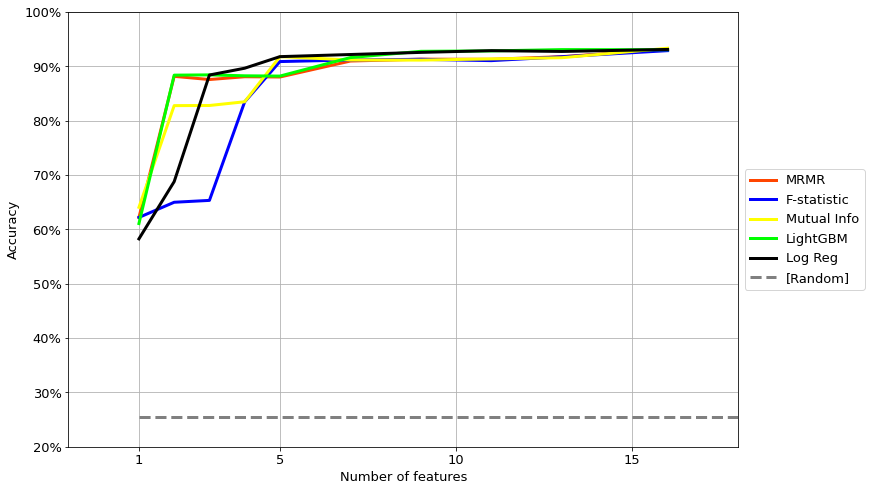

In [26]:
%time
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Plot accuracy vs features for each feature selection technique
for algo, label, color in zip(
    ['mrmr', 'f', 'mi', 'lightgbm', 'logreg'],
    ['MRMR', 'F-statistic', 'Mutual Info', 'LightGBM', 'Log Reg'],
    ['orangered', 'blue', 'yellow', 'lime', 'black']):
        plt.plot(accuracy.index, accuracy[algo], label = label, color = color, lw = 3)

plt.plot(
    [1, 20], [pd.Series(y_test).value_counts(normalize = True).iloc[0]] * 2, 
    label = '[Random]', color = 'grey', ls = '--', lw = 3
)

plt.legend(fontsize = 13, loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.grid()
plt.yticks(np.linspace(0, 1, 11), ['{:.0%}'.format(i) for i in np.linspace(0, 1, 11)], fontsize = 13)
plt.xticks([1] + list(range(5, 21, 5)), fontsize = 13)
plt.xlim(-1, 18)
plt.ylim(0.20, 1.00)
plt.xlabel('Number of features', fontsize = 13)
plt.ylabel('Accuracy', fontsize = 13)
plt.savefig('accuracy.png', dpi = 300, bbox_inches = 'tight')

It looks like MRMR and LightGBM both do a decent job with as few as 2 features, while F-statistic doesn't really even start improving until we get to 4 features. By the time we get to 7 features, all methods are 90% and while Log Reg and LightGBM appear to peak by 11 features, all methods converge at the full 16 features.  
Overall, there doesn't appear to be a clear winner or loser, but it does look like we should be able to get decent accuracy across the board with as few as 7 features. Since all of the methods increase only incrementally after 7 features, I may consider removing the bottom 4 features from the previous table ('Extent', 'Solidity', 'Eccentricity', and 'ShapeFactor3') since none of them are in the top 7 for any of the methods. That would still leave me with 12 features, which appears to be more than sufficient for a decent model, but will help to reduce CPU time and potentially overfitting.

In [27]:
# Drop least useful features
beanDF.drop(columns=['Extent', 'Solidity', 'Eccentricity', 'ShapeFactor3'], inplace=True)

## Model Selection & Evaluation
Used GridSearchCV or RandomizedSearchCV to find the best hyperparameters for each modeling type

### Split Training and Testing Data

In [28]:
# Set up features target sets
X = beanDF[beanDF.columns[:-1]]
y = beanDF.Class

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, 
                                                    random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test  = scaler.transform(X_test)

In [29]:
# Set up dictionary for model results
models_dict = {}

### Logistic Regression

In [30]:
# Create classification model
logistic = LogisticRegression(C=1000, 
                              multi_class='auto', 
                              penalty='l1', 
                              solver='liblinear', 
                              tol=0.0001,
                              class_weight='balanced', 
                              max_iter=300,
                              random_state=42, 
                              n_jobs=-1)

In [31]:
# Fit model
models_dict['Logistic'] = logistic.fit(X_train, y_train)

### Random Forest

In [32]:
# Create classification model
rfclassifier = RandomForestClassifier(criterion='entropy', 
                                      max_features='sqrt', 
                                      n_estimators=300, 
                                      random_state=42,
                                      class_weight='balanced', 
                                      n_jobs=-1)

In [33]:
# Fit model
models_dict['RandomForest'] = rfclassifier.fit(X_train, y_train)

### Decision Tree

In [34]:
# # Create classification model
# decisiontree = DecisionTreeClassifier(criterion='entropy', 
#                                       max_features='sqrt', 
#                                       splitter='best', 
#                                       random_state=42, 
#                                       class_weight='balanced')

In [35]:
# Create classification model
decisiontree = DecisionTreeClassifier(random_state=42, 
                                      class_weight='balanced')

In [36]:
# Fit model
models_dict['DecisionTree'] = decisiontree.fit(X_train, y_train)

### AdaBoost

In [37]:
# Create classification model
adaboost = AdaBoostClassifier(algorithm='SAMME', 
                              learning_rate=1, 
                              n_estimators=100, 
                              random_state=42)

In [38]:
# Fit model
models_dict['AdaBoost'] = adaboost.fit(X_train, y_train)

### Support Vector Classifier (Linear)

In [39]:
# Create classification model
linSVC = LinearSVC(C=200, 
                   dual=True,
                   loss='hinge', 
                   multi_class='crammer_singer', 
                   penalty='l1', 
                   tol=0.001,
                   random_state=42, 
                   class_weight='balanced')

In [40]:
# Fit model
models_dict['LinearSVC'] = linSVC.fit(X_train, y_train)

### Support Vector Classifier (SVC)

In [41]:
# Create classification model
svc = SVC(C=300, 
          decision_function_shape='ovo', 
          gamma='scale', 
          kernel='rbf', 
          shrinking=False, 
          random_state=42, 
          class_weight='balanced', 
          max_iter=10000)

In [42]:
# Fit model
models_dict['SVC'] = svc.fit(X_train, y_train)

### Gaussian Naive Bayes Classifier

In [43]:
# Create Gaussian naive Bayes object
nBayes = GaussianNB(var_smoothing=0.01)

In [44]:
# Fit model
models_dict['GaussianNB'] = nBayes.fit(X_train, y_train)

### MLP Classifier

In [45]:
# Create classification model
mlp = MLPClassifier(max_iter=5000, 
                    activation='relu', 
                    alpha=0.0001,
                    hidden_layer_sizes=(77, 62, 33),
                    early_stopping=True,
                    learning_rate='invscaling', 
                    solver='adam')

In [46]:
# Fit model
models_dict['MLP'] = mlp.fit(X_train, y_train)

### Keras Neural Network

In [47]:
# Encode the target variables
le = LabelEncoder()
le.fit(y)

le_y_train = le.transform(y_train)
le_y_test  = le.transform(y_test)

cat_y_train = to_categorical(le_y_train)
cat_y_test  = to_categorical(le_y_test)

#### Build the neural network

In [48]:
# Number of features
number_of_features = X.shape[1]

# Create function returning a compiled network
def create_network(optimizer='rmsprop', hiddenLayerOne=48, hiddenLayerTwo=24, 
                   learnRate=0.01):
    
    # Start neural network
    network = Sequential()
    
    # Add fully connected layer w/a ReLU activation function
    network.add(Dense(units=hiddenLayerOne, activation='relu', 
                input_shape=(number_of_features,)))

    # Add fully connected layer w/a ReLU activation function
    network.add(Dense(units=hiddenLayerTwo, activation='relu'))

    # Add fully connected layer w/a softmax activation function
    network.add(Dense(units=7, activation='softmax'))

    # Compile neural network
    network.compile(loss='categorical_crossentropy', 
                    optimizer=Adam(learning_rate=learnRate),
                    metrics=['accuracy'])

    # Return compiled network
    return network

In [49]:
# Initialize model with default values
keras = create_network( 
              learnRate=0.0001, 
              hiddenLayerOne=120, 
              hiddenLayerTwo=96)

# Train network 
history = keras.fit(X_train, cat_y_train,
              validation_data=(X_test, cat_y_test), 
              batch_size=8, 
              epochs=10)

accuracy = keras.evaluate(X_test, cat_y_test)[1]
print(f"\nAccuracy:  {round(accuracy*100, 2)}")

Epoch 1/10
1191/1191 [==============================] - 4s 3ms/step - loss: 0.8144 - accuracy: 0.7818 - val_loss: 0.3841 - val_accuracy: 0.8964
Epoch 2/10
1191/1191 [==============================] - 3s 3ms/step - loss: 0.3015 - accuracy: 0.9110 - val_loss: 0.2464 - val_accuracy: 0.9172
Epoch 3/10
1191/1191 [==============================] - 3s 3ms/step - loss: 0.2389 - accuracy: 0.9181 - val_loss: 0.2202 - val_accuracy: 0.9207
Epoch 4/10
1191/1191 [==============================] - 3s 3ms/step - loss: 0.2226 - accuracy: 0.9192 - val_loss: 0.2093 - val_accuracy: 0.9238
Epoch 5/10
1191/1191 [==============================] - 3s 3ms/step - loss: 0.2148 - accuracy: 0.9210 - val_loss: 0.2055 - val_accuracy: 0.9243
Epoch 6/10
1191/1191 [==============================] - 3s 3ms/step - loss: 0.2099 - accuracy: 0.9239 - val_loss: 0.2038 - val_accuracy: 0.9246
Epoch 7/10
1191/1191 [==============================] - 3s 3ms/step - loss: 0.2065 - accuracy: 0.9247 - val_loss: 0.2020 - val_accuracy:

In [50]:
kerasAcc = history.history['accuracy'][np.argmin(history.history['loss'])]*100
round(kerasAcc, 2)

92.55

In [51]:
# Set the number of features
number_of_features = X.shape[1]

# Start neural network
network2 = Sequential()

# Add fully connected layer w/a ReLU activation function
network2.add(Dense(units=100, activation='relu', 
                  input_shape=(number_of_features,)))

# Add fully connected layer w/a ReLU activation function
network2.add(Dense(units=100, activation='relu'))

# Add fully connected layer w/a softmax activation function
network2.add(Dense(units=7, activation='softmax'))

# Compile neural network
network2.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

In [52]:
# Fit model
history2 = network2.fit(X_train, cat_y_train, 
                      epochs=15, 
                      batch_size=5, 
                      validation_data=(X_test, cat_y_test))

accuracy = network2.evaluate(X_test, cat_y_test)[1]
print(f"\nAccuracy:  {round(accuracy*100, 2)}")

Epoch 1/15
1906/1906 [==============================] - 6s 3ms/step - loss: 0.2994 - accuracy: 0.8962 - val_loss: 0.2259 - val_accuracy: 0.9172
Epoch 2/15
1906/1906 [==============================] - 5s 3ms/step - loss: 0.2219 - accuracy: 0.9205 - val_loss: 0.2130 - val_accuracy: 0.9246
Epoch 3/15
1906/1906 [==============================] - 5s 3ms/step - loss: 0.2105 - accuracy: 0.9218 - val_loss: 0.2242 - val_accuracy: 0.9180
Epoch 4/15
1906/1906 [==============================] - 7s 4ms/step - loss: 0.2084 - accuracy: 0.9226 - val_loss: 0.2102 - val_accuracy: 0.9258
Epoch 5/15
1906/1906 [==============================] - 6s 3ms/step - loss: 0.2089 - accuracy: 0.9216 - val_loss: 0.2219 - val_accuracy: 0.9212
Epoch 6/15
1906/1906 [==============================] - 5s 3ms/step - loss: 0.2023 - accuracy: 0.9231 - val_loss: 0.1976 - val_accuracy: 0.9302
Epoch 7/15
1906/1906 [==============================] - 6s 3ms/step - loss: 0.1987 - accuracy: 0.9239 - val_loss: 0.2187 - val_accuracy:

Note: I'm not adding this one directly to the dictionary of methods because I had to categorize my target variable.

### Compare Accuracies

In [53]:
# Create lists of models and accuracy scores
modelName = []
score = []
for key in models_dict:
    modelName += [key]
    model = models_dict[key]
    value = model.score(X_test, y_test)*100
    score += [round(value, 2)]

# Add Keras accuracy
modelName += ['Keras']
kerasAcc = history.history['val_accuracy'][np.argmin(history.history['loss'])]*100
score += [round(kerasAcc, 2)]

# Create DataFrame of results
d = {'Model': modelName, 'Accuracy': score}
results = pd.DataFrame(d).sort_values(by=['Accuracy'], ascending=False)
results

,Model,Accuracy
5,SVC,92.92
7,MLP,92.80
8,Keras,92.65
4,LinearSVC,92.38
1,RandomForest,92.31
0,Logistic,92.24
6,GaussianNB,89.99
2,DecisionTree,89.20
3,AdaBoost,86.29


### Evaluate

In [54]:
# Get predictions
predictions = svc.predict(X_test)

#### Confusion matrix

In [55]:
# Print confusion matrix
cm = confusion_matrix(y_test, predictions)
print(cm)

[[366   0  19   0   1   4   5]
 [  0 161   0   0   0   0   0]
 [ 20   0 446   0   8   2   3]
 [  0   0   0 960   1  18  64]
 [  5   0   8   6 555   0  14]
 [  4   0   0   9   0 592  14]
 [  3   0   1  62   7  11 715]]


#### Classification report

In [56]:
# Print precision, recall, f1-score, and accuracy
cr = classification_report(y_test, predictions)
print(cr)

              precision    recall  f1-score   support

    BARBUNYA       0.92      0.93      0.92       395
      BOMBAY       1.00      1.00      1.00       161
        CALI       0.94      0.93      0.94       479
    DERMASON       0.93      0.92      0.92      1043
       HOROZ       0.97      0.94      0.96       588
       SEKER       0.94      0.96      0.95       619
        SIRA       0.88      0.89      0.89       799

    accuracy                           0.93      4084
   macro avg       0.94      0.94      0.94      4084
weighted avg       0.93      0.93      0.93      4084



Looks pretty good. Clearly the BOMBAY bean is sufficiently distinct from the other beans to be easily identifiable.

### Typical Beans: Create a set of mean/median bean data for testing

In [57]:
# Create a copy of the dataframe to play with
df = beanDF.copy()

In [58]:
# Group rows by values of column 'Class'. Calculate mean
df_mean = df.groupby('Class').mean()
df_mean['Class'] = df_mean.index
df_mean = df_mean.reset_index(drop=True)
df_mean.iloc[:,:-1] = scaler.transform(df_mean.iloc[:,:-1]) 
df_mean

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,ConvexArea,EquivDiameter,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor4,Class
0,0.571863,0.889560,0.580384,0.849655,-0.160584,0.580100,0.747893,-1.222732,0.086684,-1.071188,-0.539201,0.154690,BARBUNYA
1,4.108711,3.405475,3.178756,3.837092,0.006449,4.100906,3.647288,-0.144047,-0.114239,-2.768810,-1.462361,-0.732314,BOMBAY
2,0.767468,0.943321,1.039890,0.761872,0.607582,0.770367,0.954401,-0.454556,-0.697219,-0.981457,-1.020547,-1.018360,CALI
3,-0.713693,-0.886675,-0.857778,-0.814127,-0.379440,-0.714398,-0.867561,0.589847,0.315685,1.053709,0.748600,0.421912,DERMASON
4,0.020749,0.300836,0.609803,-0.401514,1.794547,0.022831,0.129933,-1.319822,-1.603255,0.390525,-1.121078,-0.712839,HOROZ
5,-0.448889,-0.595391,-0.802637,-0.006163,-1.374972,-0.453292,-0.474546,1.201138,1.577308,-0.205388,1.386588,0.756071,SEKER
6,-0.283516,-0.274806,-0.242588,-0.253760,-0.056327,-0.285175,-0.248398,0.195767,-0.037581,0.136252,-0.054422,0.073970,SIRA


In [59]:
# Group rows by values of column 'Class'. Calculate median
df_med = df.groupby('Class').median()
df_med['Class'] = df_med.index
df_med = df_med.reset_index(drop=True)
df_med.iloc[:,:-1] = scaler.transform(df_med.iloc[:,:-1]) 
df_med

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,ConvexArea,EquivDiameter,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor4,Class
0,0.564285,0.884683,0.575559,0.836562,-0.146923,0.572583,0.753592,-1.173040,0.043878,-1.091659,-0.581566,0.298054,BARBUNYA
1,4.040807,3.408359,3.149915,3.776832,0.009662,4.026093,3.619275,-0.138650,-0.139711,-2.758494,-1.492696,-0.581482,BOMBAY
2,0.741996,0.933240,1.031547,0.740483,0.608548,0.745940,0.938424,-0.443439,-0.717508,-0.974380,-1.044562,-0.862343,CALI
3,-0.721495,-0.889876,-0.857912,-0.811801,-0.402844,-0.722023,-0.870609,0.660493,0.322469,1.009033,0.703990,0.523241,DERMASON
4,0.025934,0.307998,0.630711,-0.408953,1.836907,0.027582,0.146761,-1.293937,-1.649386,0.363056,-1.161188,-0.276983,HOROZ
5,-0.472812,-0.625145,-0.827559,-0.039078,-1.411261,-0.477838,-0.501537,1.321892,1.608222,-0.180217,1.384012,0.813061,SEKER
6,-0.288160,-0.281471,-0.251833,-0.250751,-0.087579,-0.288959,-0.249325,0.227574,-0.022088,0.115422,-0.064821,0.210903,SIRA


In [60]:
# Combine data frames for testing
mean_med = df_mean.append(df_med)

# Prepare data for evaluation
mean_med_X = mean_med.iloc[:,:-1]
mean_med_y = mean_med.Class

In [61]:
# Get predictions
predictions = svc.predict(mean_med_X)

#### Confusion matrix

In [62]:
# Print confusion matrix
cm = confusion_matrix(mean_med_y, predictions)
print(cm)

[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 2 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 0 2 0 0]
 [0 0 0 0 0 2 0]
 [0 0 0 0 0 0 2]]


#### Classification report

In [63]:
# Print precision, recall, f1-score, and accuracy
cr = classification_report(mean_med_y, predictions)
print(cr)

              precision    recall  f1-score   support

    BARBUNYA       1.00      1.00      1.00         2
      BOMBAY       1.00      1.00      1.00         2
        CALI       1.00      1.00      1.00         2
    DERMASON       1.00      1.00      1.00         2
       HOROZ       1.00      1.00      1.00         2
       SEKER       1.00      1.00      1.00         2
        SIRA       1.00      1.00      1.00         2

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



Looks like the model does a fine job of classifying the mean bean.

## Conclusion

Following feature selection, several models were tried with the bean data set, including: 
* Logistic Regression
* Random Forest Classifier
* Decision Tree Classifier
* AdaBoost Classifier
* Linear SVC
* Support Vector Classifier (SVC)
* Gaussian NB
* Multi-Layer Perceptron (MLP) Classifier
* Keras Sequential Network  

Some models improved drastically with [hyperparameter tuning](https://github.com/ScottBreitbach/ScottBreitbach.github.io/blob/main/Portfolio-Projects/Beans-Classification/Hyperparameter-tuning.ipynb), like AdaBoost, while most showed only incremental improvements. Oddly, the Decision Tree model was consistently slightly worse with tuning, so I left it as-is.  

While I managed to get them all above 85% accuracy, which is decent, overall accuracy seems to have peaked around 92-93%. I suspect this is a limitation of the data itself and could probably be improved slightly by both increasing the overall number of samples in the data set as well as balancing the number of beans in the data set, since the bean with the most values (DERMASON, with a count of 3546) had roughly 7X more samples than the least represented bean (BOMBAY, with a count of 522). I didn't include it here, but I showed [previously](https://github.com/ScottBreitbach/ScottBreitbach.github.io/blob/main/Portfolio-Projects/Beans-Classification/Feature-selection.ipynb), using a Random Forest Classifier, that the accuracy continued to steadily increase as the training set size increased.  

The top two models, SVC and MLP, were very close and I cannot say for certain that one is better than the other because the results will vary slightly based on inherent randomness. That said, SVC was both easier and *much* faster to tune, so given the choice, I'd go with that one every time. While the Keras model was also pretty good, it was even more difficult to set up and tune, plus I had to encode my target variables, which was a task that was automatically handled by the other models. I also ran into more errors working with the Keras model, so I would say it is not very user friendly.  

As-is, the models seem sufficient for the task of categorizing beans and, while I believe it could be further improved with some additional data, I would feel comfortable proposing it as a solution to the problem of bean identification, uniformity, and quality. 